In [1]:
import polars as pl
import re
import copy
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from typing import List

from torch.utils.data import DataLoader, Dataset, Subset
import torch
import torch.nn as nn
from torchmetrics import Accuracy

import pytorch_lightning as ptl
import wandb
from lightning.pytorch.loggers import WandbLogger
# from lightning.pytorch.callbacks import Callbacks

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import BatchSizeFinder, LearningRateFinder, LearningRateMonitor
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score
import torchmetrics

wandb_logger = WandbLogger(project = "DNN Custom Assert", log_model=True)
# wandb_logger = WandbLogger(project = "DNN Custom Assert_En", log_model=True)
# wandb_logger = WandbLogger(project = "DNN Custom Assert", log_model=True)


# example temporal gnn https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/notebooks/a3tgcn_for_traffic_forecasting.ipynb

In [2]:
data_path = "./alert__demo_data.txt"

In [3]:
df = pl.read_csv(data_path, infer_schema_length=10000, separator=",",has_header=True)

time_to_ms_map = {
    "1 sec":1000,
    "100 ms":100,
    "over 3 mins":180000,
    "1 ms":1,
    "10 ms":10,
}

service_to_num_map = {'pop3': 0,
 'asci-val': 1,
 'epmap': 2,
 'system-unknown': 3,
 'x11': 4,
 'ideafarm-panic': 5,
 'ndl-aas': 6,
 'ssh': 7,
 'icabrowser': 8,
 'oob-ws-http': 9,
 'imap': 10,
 'ahsp': 11,
 'tripe': 12,
 'micromuse-ncpw': 13,
 'domain': 14,
 'cbserver': 15,
 'wsman': 16,
 'ms-sql-s': 17,
 'coherence': 18,
 'pdl-datastream': 19,
 'pop3s': 20,
 'spt-automation': 21,
 'icmp': 22,
 'telelpathstart': 23,
 'apc-3052': 24,
 'ntp': 25,
 'soundsvirtual': 26,
 'search-agent': 27,
 'snmptls': 28,
 'icmpd': 29,
 'private-unknown': 30,
 'microsoft-ds': 31,
 'registered-unknown': 32,
 'www-http': 33}
#{t:i for i,t in enumerate(x)}


ip_manuever_to_int = {'UNDETERMINED_SAME_SRC_NEW_DST': 1,
 'UNDETERMINED_SAME_DST_NEW_SRC': 2,
 'UNDETERMINED_NO_CHANGE': 0,
 'UNDETERMINED_NEW_SRC_NEW_DST': 3,
 'UNDETERMINED_NEW_DST_IS_PRV_SRC': 4,
 'OUTBOUND_SAME_DST_NEW_SRC': 5,
 'OUTBOUND_NO_CHANGE': 6,
 'OUTBOUND_NEW_SRC_NEW_DST': 7,
 'INTERNAL_SAME_SRC_NEW_DST': 8,
 'INTERNAL_NO_CHANGE': 9,
 'INTERNAL_NEW_SRC_NEW_DST': 10,
 'INBOUND_SAME_SRC_NEW_DST': 11,
 'INBOUND_NO_CHANGE': 12,
 'INBOUND_NEW_SRC_NEW_DST': 13}

is_ip_maneuver = lambda x: min(1,x)

attack_stage_to_int = {'VULN_DISC': 1,
 'PRIV_ESC': 2,
 'NETWORK_DISC': 1,
 'INFO_DISC': 1,
 'DATA_EXFILTRATION': 3,
 'CREDENTIAL_ACCESS': 2,
 'COMMAND_AND_CONTROL': 3,
 'CODE_EXECUTION': 2}

df = df.with_columns(
    [pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S%.f").alias("timestamp"),
     pl.col("timestamp_relative").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S%.f").alias("timestamp_relative"),
     pl.col("ext_asn_derivation").cast(pl.Int64()).fill_null(strategy="zero").alias("ext_asn_derivation"),
     pl.col("time_elapsed").map_dict(time_to_ms_map, return_dtype=pl.Int64).alias("time_elapsed"),
     pl.col("service_name").map_dict(service_to_num_map),#.cast(pl.Categorical).to_physical()
     pl.col("ip_maneuver").map_dict(ip_manuever_to_int),
     pl.col("attack_stage").map_dict(attack_stage_to_int)
    ])

In [4]:
df.head()

instance,timestamp,model_id,alert_id,timestamp_relative,ext_asn_derivation,service_name,time_elapsed,ip_maneuver,attack_stage
str,datetime[ns],i64,str,datetime[ns],i64,i64,i64,i64,i64
"""fa0d2a31-647c-…",2021-03-09 05:07:17.160,1,"""61459c7d12d922…",2020-08-07 16:20:04.281,0,16,10,0,3
"""fa0d2a31-647c-…",2021-03-09 05:07:17.160,1,"""dbcc5f241a02ab…",2020-08-07 16:20:04.281,0,16,100,0,3
"""fa0d2a31-647c-…",2021-03-09 05:07:17.160,1,"""50c4a40592c3f5…",2020-08-07 16:20:04.281,0,16,10,0,3
"""fa0d2a31-647c-…",2021-03-09 05:07:17.160,1,"""ad3ac3d73c2ff5…",2020-08-07 16:20:04.281,0,16,100,0,3
"""fa0d2a31-647c-…",2021-03-09 05:07:17.160,1,"""1af587cd531069…",2020-08-07 16:20:04.281,0,16,1000,0,3


In [5]:
df.columns

['instance',
 'timestamp',
 'model_id',
 'alert_id',
 'timestamp_relative',
 'ext_asn_derivation',
 'service_name',
 'time_elapsed',
 'ip_maneuver',
 'attack_stage']

In [6]:
# #df.with_columns(pl.col("service_name").categorical())
service_ip_col = df.select([pl.col("service_name"), pl.col("ip_maneuver")])
df = df.to_dummies(columns=["service_name", "ip_maneuver"])

In [7]:
def get_attributes( df_slice: pl.dataframe.frame.DataFrame):
    service_dict = {f'collective_service_name_{i}':df_slice[f'collective_service_name_{i}'].sum() for i in np.arange(34)}
    ip_dict = {f'collective_ip_maneuver_{i}':df_slice[f'collective_ip_maneuver_{i}'].sum() for i in np.arange(14)}
    other_attributes = {
        
        #'collective_timestamp_relative': df_slice['collective_timestamp_relative'].mean(), include in better dataset
        'collective_ext_asn_derivation': df_slice['collective_ext_asn_derivation'].mean() if len(df_slice) > 0 else 0,
        'collective_time_elapsed': df_slice['collective_time_elapsed'].mean() if len(df_slice) > 0 else 0,
        #'collective_ip_maneuver': df_slice['collective_ip_maneuver'].map_elements(is_ip_maneuver).sum() if len(df_slice) > 0 else 0
    }
    return pl.DataFrame({**service_dict,**other_attributes, **ip_dict})


In [8]:
# fix the time_seq
time_seqS = (pl.select(df['timestamp_relative']) + pl.select(df["time_elapsed"])).to_series().rename("time_seq")
df.insert_column(-1, time_seqS) if "time_seq" not in df.columns else None

df.sort(by=["model_id", "timestamp_relative"])
df = df.drop(['alert_id', 'instance', 'timestamp']) # remove columns with single values or rundundancies
df = df.with_columns([pl.col(col).alias("collective_"+col) for col in df.columns])
df = df.drop(["collective_timestamp_relative"]) # in a better dataset collective_timestamp_relative might be kept
#df = df.with_columns([pl.col("service_name").alias("collective_service_name_1"), pl.col("service_name").alias("collective_service_name_2")])
var = []
var_col = []
for j in df["model_id"].unique():
    globals()[f"x_{j}"] = df.filter(pl.col("model_id") == j)
    var_sub_row = [get_attributes(df.slice(0,0))]
    for i in np.arange(len(globals()[f"x_{j}"])-1)+1:
        globals()[f"x_{j}"]=globals()[f"x_{j}"].with_columns([ pl.col("time_seq") + pl.concat([pl.Series([0]*i),globals()[f"x_{j}"]["time_elapsed"].slice(0,len(globals()[f"x_{j}"])-i)]) ])
        var_sub_row.append(get_attributes(globals()[f"x_{j}"].slice(0,i)))
    var.append(globals()[f"x_{j}"])
    var_col.extend(var_sub_row)
    
#df = pl.concat([pl.concat(var),pl.concat(var_col, how="align")],how="diagonal_relaxed").sort(by=["model_id", "time_seq"])

In [9]:
pl.concat(var).columns

['model_id',
 'timestamp_relative',
 'ext_asn_derivation',
 'service_name_0',
 'service_name_1',
 'service_name_10',
 'service_name_11',
 'service_name_12',
 'service_name_13',
 'service_name_14',
 'service_name_15',
 'service_name_16',
 'service_name_17',
 'service_name_18',
 'service_name_19',
 'service_name_2',
 'service_name_20',
 'service_name_21',
 'service_name_22',
 'service_name_23',
 'service_name_24',
 'service_name_25',
 'service_name_26',
 'service_name_27',
 'service_name_28',
 'service_name_29',
 'service_name_3',
 'service_name_30',
 'service_name_31',
 'service_name_32',
 'service_name_33',
 'service_name_4',
 'service_name_5',
 'service_name_6',
 'service_name_7',
 'service_name_8',
 'service_name_9',
 'time_elapsed',
 'ip_maneuver_0',
 'ip_maneuver_1',
 'ip_maneuver_10',
 'ip_maneuver_11',
 'ip_maneuver_12',
 'ip_maneuver_13',
 'ip_maneuver_2',
 'ip_maneuver_3',
 'ip_maneuver_4',
 'ip_maneuver_5',
 'ip_maneuver_6',
 'ip_maneuver_7',
 'ip_maneuver_8',
 'ip_maneuver_9'

In [10]:
collective = pl.concat(var_col,how="vertical_relaxed")
# df = pl.concat(var).with_columns([
#     pl.col(col) = collective[col] for col in collective.columns
# ])
partial = pl.concat(var)
columns_to_drop = [col for col in partial.columns if col in collective.columns]
partial = partial.drop(columns_to_drop)
df = partial.hstack(collective)

In [11]:
ips = [print(col) for col in df.columns if "ip_man" in col]

ip_maneuver_0
ip_maneuver_1
ip_maneuver_10
ip_maneuver_11
ip_maneuver_12
ip_maneuver_13
ip_maneuver_2
ip_maneuver_3
ip_maneuver_4
ip_maneuver_5
ip_maneuver_6
ip_maneuver_7
ip_maneuver_8
ip_maneuver_9
collective_ip_maneuver_0
collective_ip_maneuver_1
collective_ip_maneuver_2
collective_ip_maneuver_3
collective_ip_maneuver_4
collective_ip_maneuver_5
collective_ip_maneuver_6
collective_ip_maneuver_7
collective_ip_maneuver_8
collective_ip_maneuver_9
collective_ip_maneuver_10
collective_ip_maneuver_11
collective_ip_maneuver_12
collective_ip_maneuver_13


In [12]:
df.head()

model_id,timestamp_relative,ext_asn_derivation,service_name_0,service_name_1,service_name_10,service_name_11,service_name_12,service_name_13,service_name_14,service_name_15,service_name_16,service_name_17,service_name_18,service_name_19,service_name_2,service_name_20,service_name_21,service_name_22,service_name_23,service_name_24,service_name_25,service_name_26,service_name_27,service_name_28,service_name_29,service_name_3,service_name_30,service_name_31,service_name_32,service_name_33,service_name_4,service_name_5,service_name_6,service_name_7,service_name_8,service_name_9,…,collective_service_name_13,collective_service_name_14,collective_service_name_15,collective_service_name_16,collective_service_name_17,collective_service_name_18,collective_service_name_19,collective_service_name_20,collective_service_name_21,collective_service_name_22,collective_service_name_23,collective_service_name_24,collective_service_name_25,collective_service_name_26,collective_service_name_27,collective_service_name_28,collective_service_name_29,collective_service_name_30,collective_service_name_31,collective_service_name_32,collective_service_name_33,collective_ext_asn_derivation,collective_time_elapsed,collective_ip_maneuver_0,collective_ip_maneuver_1,collective_ip_maneuver_2,collective_ip_maneuver_3,collective_ip_maneuver_4,collective_ip_maneuver_5,collective_ip_maneuver_6,collective_ip_maneuver_7,collective_ip_maneuver_8,collective_ip_maneuver_9,collective_ip_maneuver_10,collective_ip_maneuver_11,collective_ip_maneuver_12,collective_ip_maneuver_13
i64,datetime[ns],i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,2020-08-07 16:20:04.281,10439,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2020-08-07 16:20:04.281,10439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10439.0,1000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,2020-08-07 16:20:04.281,10439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10439.0,1000.0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
0,2020-08-07 16:20:04.281,202425,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10439.0,1000.0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
0,2020-08-07 16:20:04.281,202425,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58435.5,1000.0,0,0,0,0,0,0,0,0,0,0,0,4,0,0


In [13]:
df.drop_in_place("model_id");

In [14]:
df.drop_in_place("collective_model_id");

In [15]:
df = df.to_dummies("attack_stage")

In [16]:
df.null_count().max_horizontal()

max
u32
0


In [17]:
ips = [col for col in df.columns if "ip_man" in col]
services = [col for col in df.columns if "service_n" in col]
others = [col for col in df.columns if col not in ips and col not in services and "attack_stage" not in col]
attacks = [col for col in df.columns if col not in ips and col not in services and col not in others]
df = df.select(others+ips+services+attacks)
# norm_others = [timestamp_relative]


sorted_services = [f'collective_service_name_{i}' for i in np.arange(34)]
# sorted_services.extend([f'collective_service_name_{i}' for i in np.arange(34)])
sorted_ip = [f'collective_ip_maneuver_{i}' for i in np.arange(14)]
# sorted_ip.extend([f'collective_ip_maneuver_{i}' for i in np.arange(14)])
sorted_columns = copy.deepcopy(others)
sorted_columns.extend(sorted_services)
sorted_columns.extend(sorted_ip)
df = df.select(sorted_columns+attacks).insert_column(4, service_ip_col["service_name"]).insert_column(5, service_ip_col["ip_maneuver"])

In [18]:
df.select(others).describe()

describe,timestamp_relative,ext_asn_derivation,time_elapsed,time_seq,collective_time_seq,collective_ext_asn_derivation,collective_time_elapsed
str,str,f64,f64,f64,f64,f64,f64
"""count""","""4000""",4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,38508.8435,13105.21625,1.5968e18,1.5968e18,31806.566694,10391.008512
"""std""",null,67234.361623,45619.608594,2.6232e11,2.6232e11,53432.270098,14582.393068
"""min""","""2020-08-07 16:…",0.0,1.0,1.5968e18,1.5968e18,0.0,0.0
"""25%""",null,0.0,100.0,1.5968e18,1.5968e18,0.0,1403.616438
"""50%""",null,2914.0,1000.0,1.5968e18,1.5968e18,2914.0,7554.267261
"""75%""",null,49877.0,1000.0,1.5968e18,1.5968e18,56048.0,15807.302564
"""max""","""2020-08-07 16:…",264668.0,180000.0,1.5968e18,1.5968e18,204601.0,180000.0


In [19]:
def std(col):
    return (pl.col(col) - pl.col(col).mean())/pl.col(col).std()

def norm(col):
    return (pl.col(col) - pl.col(col).min())/(pl.col(col).max() - pl.col(col).min())

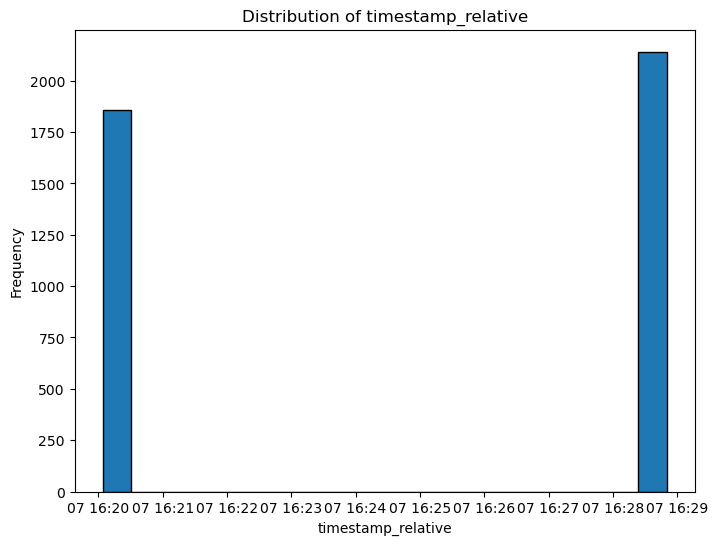

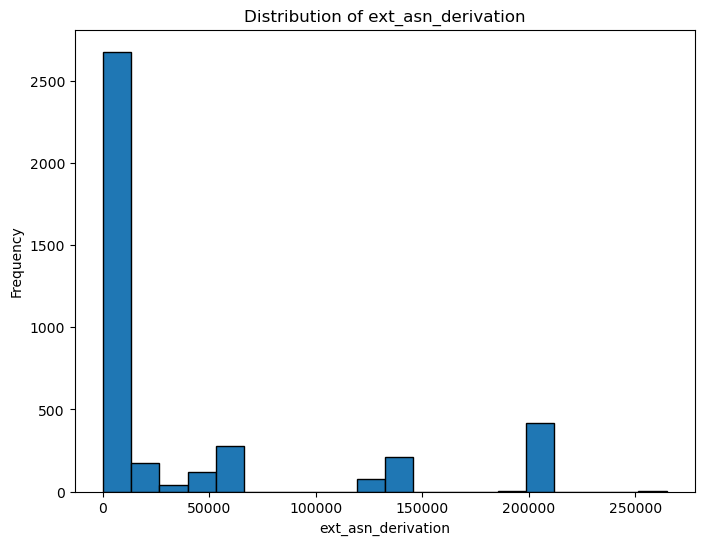

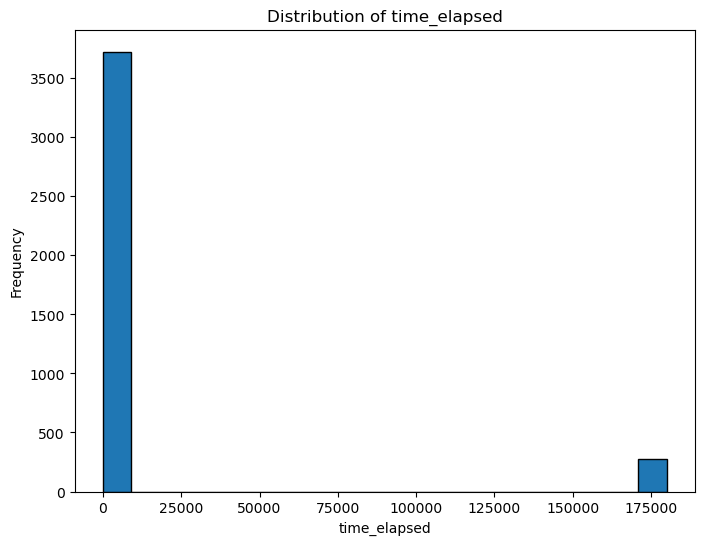

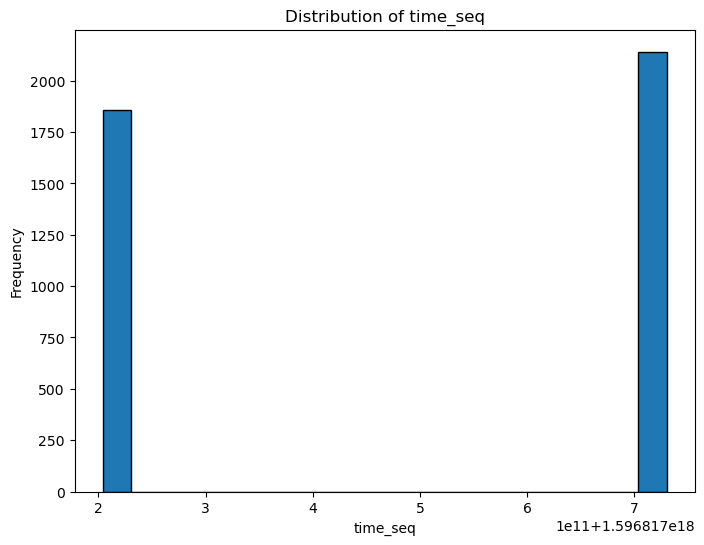

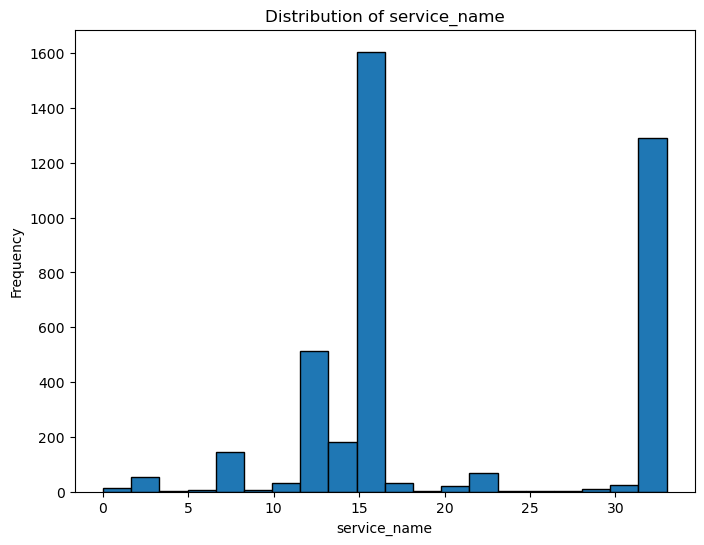

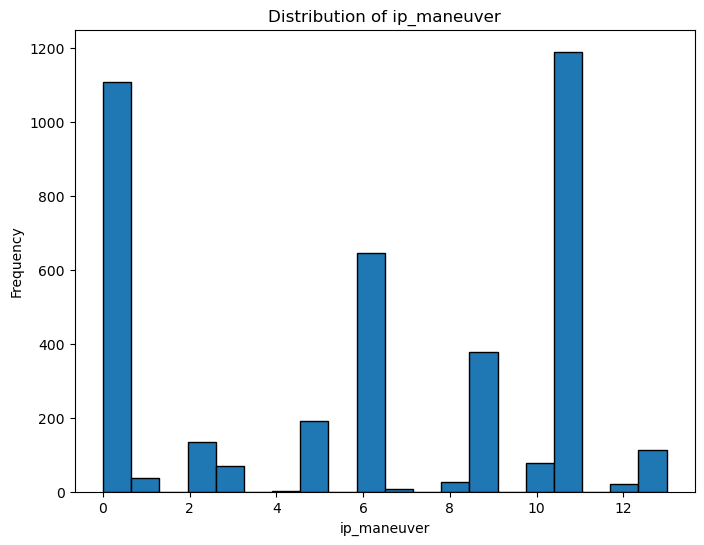

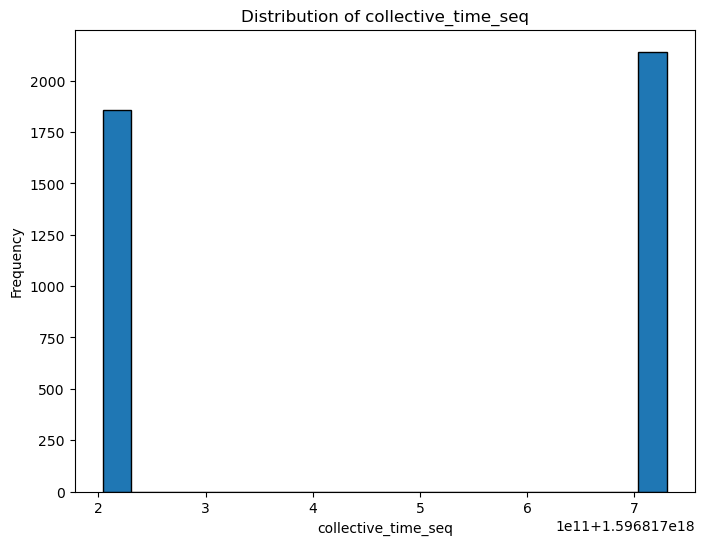

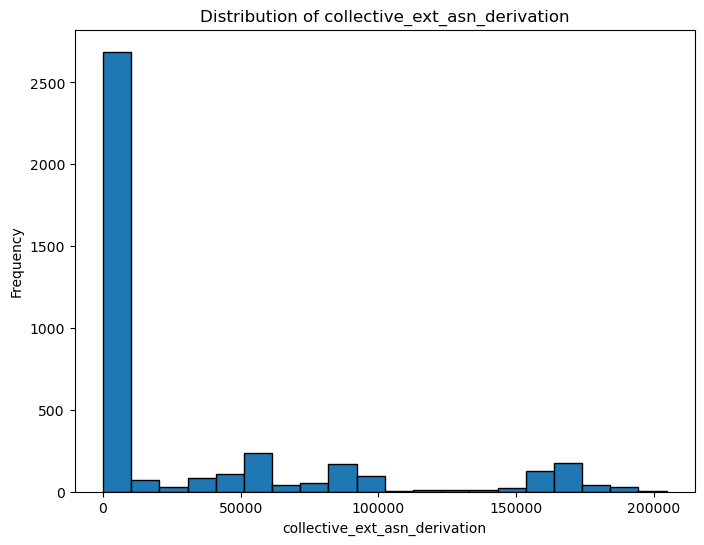

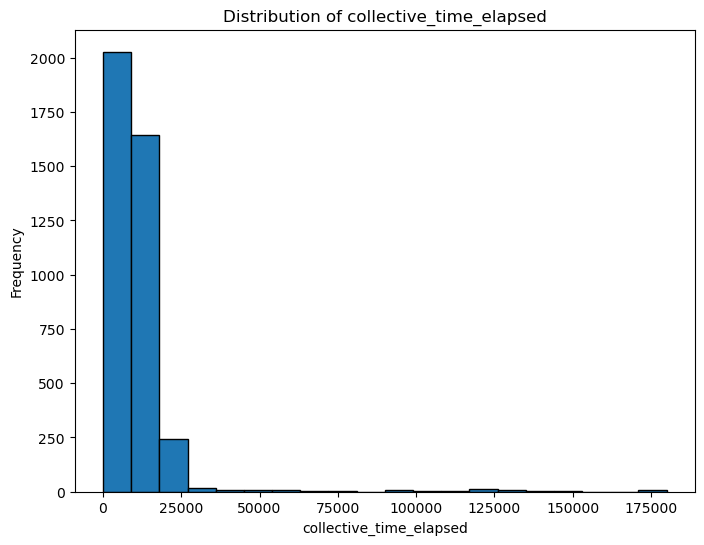

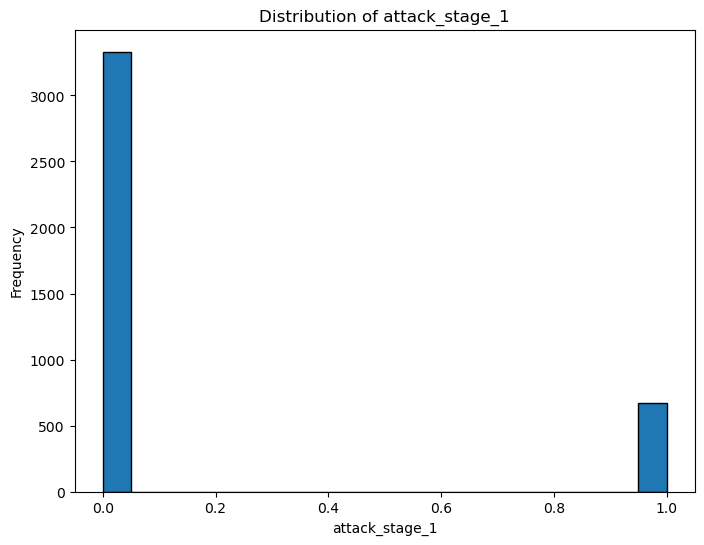

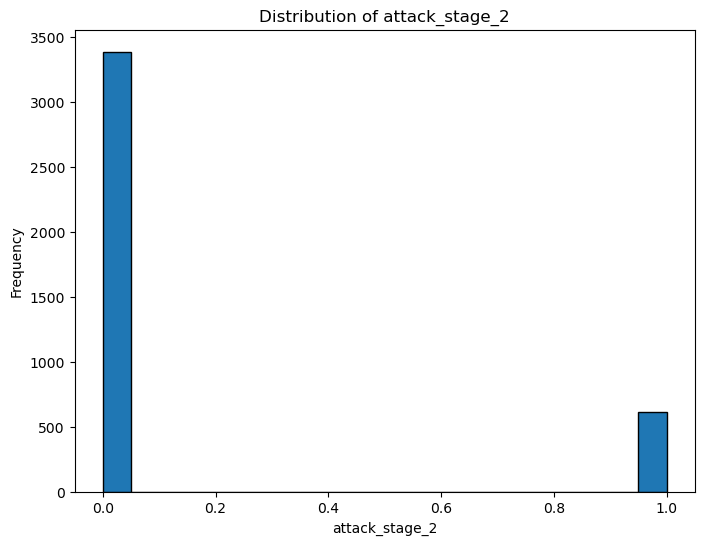

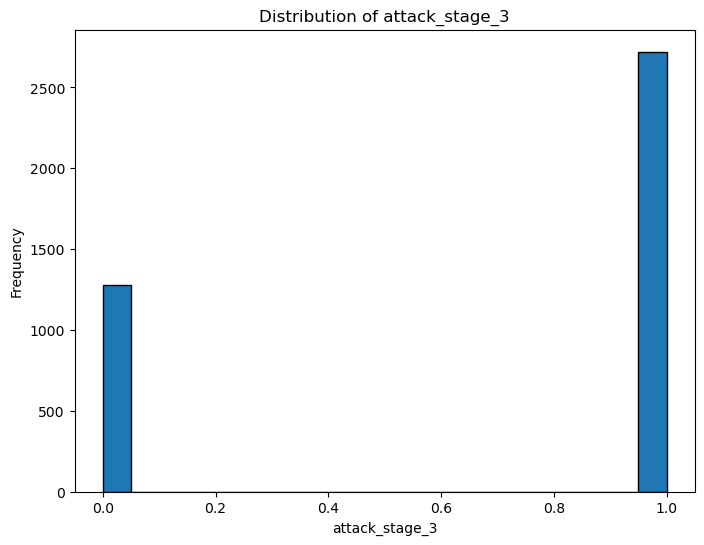

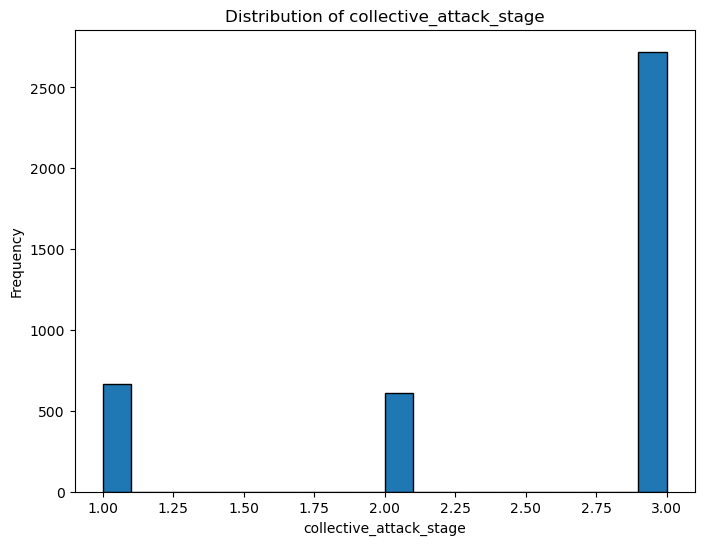

In [20]:
import matplotlib.pyplot as plt
import polars as pl

def plot_distributions(data_frame):
    """
    Plot the distribution of all columns in a Polars DataFrame using Matplotlib.

    Parameters:
    - data_frame: Polars DataFrame
    """
    # Get column names
    column_names = data_frame.columns

    # Plot each column's distribution
    for column_name in column_names:
        if column_name in ips or column_name in services:
            continue
        column_data = data_frame[column_name].to_numpy()
        
        # Create a histogram
        plt.figure(figsize=(8, 6))
        plt.hist(column_data, bins=20, edgecolor='black')
        
        # Set labels and title
        plt.title(f'Distribution of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        
        # Show the plot
        plt.show()


# Plot distributions
plot_distributions(df)


In [21]:
mean = df.mean()
df_std = df.std()
df_min = df.min()
df_max = df.max()

df.drop_in_place("collective_attack_stage")
normalized = df.with_columns(
    [
        norm("timestamp_relative"),
        std("time_seq"),
        norm("ext_asn_derivation"),    
        norm("time_elapsed"),
        norm("collective_time_seq"),
        (pl.col("collective_ext_asn_derivation") - pl.col("collective_ext_asn_derivation").mean())/pl.col("collective_ext_asn_derivation").std(),
        norm("collective_time_elapsed")
    ]
)


In [22]:
others

['timestamp_relative',
 'ext_asn_derivation',
 'time_elapsed',
 'time_seq',
 'collective_time_seq',
 'collective_ext_asn_derivation',
 'collective_time_elapsed']

In [23]:
col_dict = {"standard_attributes":[],"service_attributes":[], "ip_attributes":[],"attack_attributes":[]}
for i,x in enumerate(normalized.columns):
    if "ip_m" in x:
        col_dict["ip_attributes"].append(i)
    elif "service" in x:
        col_dict["service_attributes"].append(i)
    elif "attack" in x:
        col_dict["attack_attributes"].append(i)
    else:
        col_dict["standard_attributes"].append(i)
            
        

In [24]:
num_cores = 0 # Ideally this should be the number of cores to be used, 0 means use the main process, my computer can only use 0
# If num_cores > 0 use persistent workers in the dataloader class

In [25]:
class attack_data(Dataset):
    def __init__(self, all_ip_data):
        super().__init__()
        self.all_ip_data = torch.tensor(all_ip_data.to_numpy())
        self.size = len(self.all_ip_data)
        
    def __len__(self):
        return len(self.all_ip_data)

    def __getitem__(self, idx):
        return self.all_ip_data[idx, col_dict["standard_attributes"]].float(), self.all_ip_data[idx, col_dict["service_attributes"]].int(), self.all_ip_data[idx, col_dict["ip_attributes"]].int(), self.all_ip_data[idx, col_dict["attack_attributes"]].float() 


class dataloader(ptl.LightningDataModule):
    def __init__(self, train, val, test, batch_size ):
        super().__init__()
        self.train_dataset = attack_data(train)
        self.val_dataset = attack_data(val)
        self.test_dataset = attack_data(test)
        self.batch_size = batch_size
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle = True, num_workers = num_cores, pin_memory=True,)# persistent_workers=True)
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle = False, num_workers = num_cores, pin_memory=True,)# persistent_workers=True)
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle = False, num_workers = num_cores, pin_memory=True,)# persistent_workers=True)


In [26]:
# # set up two neural network classes using pytorch lightning, all forward calls need a softmax applied at the end for production,


# class DenseNeural(pl.LightningModule):
#     def __init__(self, num_classes = 10, feature_columns = 80, modelIsPartofAnother=False, AE=False):
#         ''' 
#         num_classes is the number of output for the output layer
#         feature_columns is the number of input for the input layer
#         modelIsPartofAnother and AE are both variables for Autoencoder logic
#         '''
#         super().__init__()
#         self.fc1 = nn.Linear(feature_columns,int(feature_columns/2))
#         self.fc2 = nn.Linear(int(feature_columns/2), int(feature_columns/4))
#         self.fc3 = nn.Linear(int(feature_columns/4), num_classes)
#         self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
#         self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
#         self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        
#         self.cross_entropy_loss_function = nn.CrossEntropyLoss()
#         self.modelIsPartofAnother=modelIsPartofAnother
#         self.AE = AE

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = F.relu(self.fc2(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc3(x)
#         # Normally the F.softmax would be called here but the cross entropy loss should do that
#         return x
    
#     def configure_optimizers(self):
#         return torch.optim.SGD(self.parameters(), lr=.001, momentum=0.5) #maybe try adam?
    
#     def cross_entropy_loss(self, logits, labels):
#         return self.cross_entropy_loss_function(logits,labels.long())
    
#     def loss(self,x,y):
#         logits = self.forward(x)
#         loss_value = self.cross_entropy_loss(logits,y)
#         return logits, loss_value
        
#     def training_step(self, batch, batch_idx):    
#         self.training = True
#         x,y = batch
#         logits, loss = self.loss(x,y)
        
#         # if the model is doing decoder logic we don't want the accuracy
#         if not self.modelIsPartofAnother and not self.AE:
#             self.train_acc(F.softmax(logits,1),y)
#             self.log("train_acc", self.train_acc, on_epoch=True)
#         self.log('train_loss', loss, on_epoch=True)

#         return loss
    
    
#     def validation_step(self, batch, batch_idx, k=10):
        
#         self.training = False
#         x,y = batch
#         logits, loss = self.loss(x,y)
        
#         # if the model is doing decoder logic we don't want the accuracy
#         if not self.modelIsPartofAnother and not self.AE:
#             self.val_acc(F.softmax(logits,1),y)
#             self.log("val_acc", self.val_acc, on_epoch=True)
#         self.log('val_loss', loss, on_epoch=True)

#         return logits
    
#     # Not called
#     def test_step(self, batch, batch_idx): #might no use
#         self.training = False
#         x,y = batch
#         logits, loss = self.loss(x,y)
#         self.test_acc(F.softmax(logits,1),y)
#         self.log('test_loss', loss, on_epoch=True, on_step=False)
#         self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)
#         # return loss
        
# # This is the auto encoder class, it copies the Dense Neural class but has addisitonal Dense Neurals for the decoder/encoder
# class AutoEncoder(DenseNeural):
#     def __init__(self, feature_columns=80, num_classes=10, intermediate_layer = 25):
#         super().__init__(num_classes,feature_columns,AE=True)
#         self.encoder = DenseNeural(num_classes=intermediate_layer,feature_columns=feature_columns, modelIsPartofAnother=True)
#         self.decoder = DenseNeural(num_classes=feature_columns, feature_columns=intermediate_layer, modelIsPartofAnother=True)

#         # loss for mean decoder
#         self.loss_function = MeanSquaredError()
    
#     def forward(self, x):
#         if self.AE: #Autoencoder step
#             return self.decoder.forward(F.relu(self.encoder.forward(x)))
#         else: #Finetuning
#             x = self.encoder.forward(x,modelIsPartofAnother=False)
#             x = F.relu(self.fc1(x))
#             x = F.dropout(x, training=self.training)
#             x = F.relu(self.fc2(x))
#             return x
        
        
#     # The same thing as the parent class's loss method, but the loss function is different
#     def loss(self,x,y):
#         if self.AE:
#             logits = self.forward(x)
#             loss_value = self.loss_function(logits,x)
#             return logits, loss_value
#         else:
#             # This will use the cross entropy loss
#             return super().loss(x,y) 

# aeServiceModel = AutoEncoder(feature_columns=34, num_classes=18,intermediate_layer=20)
# aeServiceLogger = WandbLogger(project = "DNN Custom Assert Encoding Service", log_model=True)
# aeServicetrainer = pl.Trainer(logger=aeServiceLogger, max_epochs=200, deterministic=True, callbacks=[EarlyStopping(monitor="val_loss", mode="min")],  accelerator="auto", devices="auto", strategy="auto")
# aeServicetrainer.fit(aeServiceModel,train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
# aeServiceModel.AE = False
# # finetune
# aeServicetrainer.fit(aeModel,train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [27]:
class DenseNeuralModel(ptl.LightningModule):
    def __init__(self, num_classes = 3, feature_columns = 7): #fixme change log chance
        ''' 
        num_classes is the number of output for the output layer
        feature_columns is the number of input for the input layer minus the output of the embedding layer
        '''
        super(DenseNeuralModel,self).__init__()
        self.embedding_service_name = nn.Embedding(34, embedding_dim=18, sparse=False)
        self.embedding_ip_maneuver = nn.Embedding(14, embedding_dim=9,sparse=False)
        
        feature_columns += 18+9 + 18+9
        
        self.fc1 = nn.Linear(feature_columns,int(feature_columns/2))
        self.fc2 = nn.Linear(int(feature_columns/2), int(feature_columns/4))
        self.fc3 = nn.Linear(int(feature_columns/4), num_classes)
        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = MulticlassF1Score(num_classes=num_classes)
        self.test_precision = torchmetrics.Precision(task="multiclass",num_classes=num_classes)
        self.test_recall = torchmetrics.Recall(task="multiclass",num_classes=num_classes)
        
        self.cross_entropy_loss_function = nn.CrossEntropyLoss()
        self.mode =None
        
        self.lr = .000001

    def forward(self, x, service_names, maneuvers):
            
        x_service_collective = F.normalize(self.one_hot_to_tensor(service_names[:,1:], self.embedding_service_name))
        x_service = F.normalize(self.embedding_service_name(service_names[:,0]))
        x_ip_collective = F.normalize(self.one_hot_to_tensor(maneuvers[:,1:], self.embedding_ip_maneuver))
        x_ip = F.normalize(self.embedding_ip_maneuver(maneuvers[:,0]))
        
        x = torch.hstack([x,x_service,x_ip,x_service_collective,x_ip_collective])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, .4,training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, .3, training=self.training)
        x = self.fc3(x)
        return x
    
    def one_hot_to_tensor(self, one_hot, embedding):
        return one_hot.float()@embedding.weight.data
            

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr) 
    
    def cross_entropy_loss(self, logits, labels):
        return self.cross_entropy_loss_function(logits,labels)
    
    def loss(self,x, x_serv, x_man, y):
        logits = self.forward(x, x_serv, x_man)
        loss_value = self.cross_entropy_loss(logits,y)
        
        prediction = F.softmax(logits,1).argmax(axis=1)
        truth = y.argmax(axis=1)
        self.log_dict({f'{self.mode}_loss': loss_value, 
                       f"{self.mode}_acc": self.test_acc(prediction,truth),
                      f'{self.mode}_f1':self.test_f1(prediction, truth),
                      f'{self.mode}_precison':self.test_precision(prediction, truth),
                      f'{self.mode}_recall':self.test_recall(prediction, truth)}, on_epoch=True)
        return logits, loss_value
        
    def training_step(self, batch, batch_idx):
        self.training = True
        self.mode = "train"
        x, x_serv, x_man, y = batch
        logits, loss = self.loss(x, x_serv, x_man, y)

        return loss
    
    
    def validation_step(self, batch, batch_idx, k=10):
        
        self.training = False
        self.mode = "val"
        x, x_serv, x_man, y = batch
        logits, loss = self.loss(x, x_serv,x_man, y)
        
        return logits
    
    def test_step(self, batch, batch_idx): #might no use
        self.training = False
        self.mode = "test"
        x, x_serv,x_man, y = batch
        logits, loss = self.loss(x, x_serv,x_man, y)
        
        

trainer = ptl.Trainer(accumulate_grad_batches=4, 
            deterministic=True, 
            check_val_every_n_epoch=4, 
            devices="auto", # fix to the specific one we will use
            accelerator="auto", # change from auto to gpu 
            enable_checkpointing=True,
            max_epochs=10000,
            log_every_n_steps=40,
            logger=wandb_logger,
            #max_time={"days": 1, "hours": 5} stops after the specified time
            strategy="auto",
            callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=25), LearningRateFinder(early_stop_threshold=25), LearningRateMonitor(logging_interval="step")], #BatchSizeFinder()
            benchmark=True,
           )
        
 

C:\Users\Charl\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:630: You passed `deterministic=True` and `benchmark=True`. Note that PyTorch ignores torch.backends.cudnn.deterministic=True when torch.backends.cudnn.benchmark=True.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
indecies = np.arange(len(normalized))
np.random.shuffle(indecies)
train_index, val_index, test_index = indecies[:int(len(indecies)*.60)], indecies[int(len(indecies)*.60): int(len(indecies)*.80)], indecies[int(len(indecies)*.80):]
assert len(train_index)+len(test_index)+len(val_index) == len(indecies), "Error, some data is missing in split"

loader = dataloader(normalized[train_index], normalized[val_index], normalized[test_index], 64)
#loader = dataloader(normalized, normalized, normalized, 64)
model = DenseNeuralModel()
wandb_logger.watch(model, log_freq=40) #Shows gradients
trainer.fit(model, train_dataloaders=loader.train_dataloader(), val_dataloaders=loader.val_dataloader())
trainer.test(model=model, dataloaders=loader.test_dataloader())